# KKBox Churn Prediction Modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as ms
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
train = pd.read_csv('C:\\Users\\dgurram\\Desktop\\Capstone\\train_v2.csv')
#train = pd.read_csv('/Users/dineshviswatejagurram/Desktop/train_v2.csv')

# Members.

In [4]:
members = pd.read_csv('C:\\Users\dgurram\Desktop\Capstone\members_v3.csv')
#members = pd.read_csv('/Users/dineshviswatejagurram/Desktop/members_v3.csv') 
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [5]:
x1 = pd.merge(train, members, on = 'msno', how = 'left')

In [6]:
x1 = x1.drop(['bd', 'gender'], axis = 1)
x1 = x1.dropna(axis = 0, how = 'any')

x1['registration_init_time'] = pd.to_datetime(x1['registration_init_time'], format = "%Y%m%d")
x1['registration_init_time_year'] = x1['registration_init_time'].apply(lambda date : date.year)
x1['registration_init_time_month'] = x1['registration_init_time'].apply(lambda date : date.month)
x1['registration_init_time_day'] = x1['registration_init_time'].apply(lambda date : date.day)

x1 = x1.drop('registration_init_time', 1)
x1.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25


# Transactions.

In [7]:
transactions_1 = pd.read_csv('C:\\Users\\dgurram\\Desktop\\Capstone\\transactions.csv')
transactions = transactions_1.append(pd.read_csv('C:\\Users\\dgurram\\Desktop\\Capstone\\transactions_v2.csv'))

In [8]:
grouped = transactions.copy().groupby('msno')
y1 = grouped.agg({'msno' :{'trans_count': 'count'},
                       'payment_plan_days' :{'transaction_span': 'sum'},
                       'plan_list_price' :{'total_list_price':'sum'},
                       'actual_amount_paid' : {'total_amount_paid' : 'sum'},
                       'is_auto_renew' :{'is_auto_renew': 'max'},
                       'is_cancel' : {'is_cancel_sum': 'sum'}})

y1.columns = y1.columns.droplevel(0)
y1.reset_index(inplace = True)

y1['difference_in_price_paid'] = y1['total_list_price'] - y1['total_amount_paid']
y1['amount_paid_perday'] = y1['total_amount_paid'] / y1['transaction_span']
y1.head()

C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,msno,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,7,0,0,0,0,0,0.000000
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,805,3387,3387,0,0,0,4.207453
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,150,495,495,1,0,0,3.300000
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,603,2980,3129,1,0,-149,5.189055
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,780,3874,4023,1,0,-149,5.157692


In [9]:
y2 = transactions.sort_values('transaction_date', ascending = False).reset_index(drop = True)
y2 = y2.drop_duplicates(subset = ['msno'], keep = 'first')
y2 = y2.drop(['is_auto_renew', 'membership_expire_date'], 1)
y2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,transaction_date,is_cancel
0,nlwI4rVeDrFDFjkHBXuMBBXAWvhTv9miDiEGdaMDiXs=,41,30,99,99,20170331,0
1,GOKnXKY9XXaf3PaL9seD4HENmWw3o5WFUKTKL2irFrA=,39,30,149,149,20170331,0
2,TJ6nxPb8NDfeKb8HpZz2HemVvZHZdS52OJdMYFCZHv4=,41,30,99,99,20170331,0
3,9NwzFDrPGKgEuLKrM7EXsqg+VtebHhJ5WJFDOWhY4bQ=,41,30,99,99,20170331,0
4,TM/4vR23dnG79lZCqimPzRLBCq6RlG3ibOqs1Wd9IgY=,34,30,149,149,20170331,0


In [10]:
x2 = pd.merge(x1, y2, on = 'msno', how = 'left')
x2 = pd.merge(x2, y1, on = 'msno', how = 'left')
x2.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date,is_cancel,trans_count,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,20170228,0,6,60,298,894,1,1,-596,14.900000
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,20170311,0,6,157,807,807,0,0,0,5.140127
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,20170314,0,20,690,2982,2982,0,0,0,4.321739
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,20160225,1,29,787,3874,4172,1,3,-298,5.301144
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,20170316,0,32,870,3321,3748,1,3,-427,4.308046


In [11]:
x2['transaction_date'] = pd.to_datetime(x2['transaction_date'], format = "%Y%m%d")
x2['transaction_date_year'] = x2['transaction_date'].apply(lambda date : date.year)
x2['transaction_date_month'] = x2['transaction_date'].apply(lambda date : date.month)
x2['transaction_date_day'] = x2['transaction_date'].apply(lambda date : date.day)

x2 = x2.drop('transaction_date', 1)
x2.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_span,total_list_price,total_amount_paid,is_auto_renew,is_cancel_sum,difference_in_price_paid,amount_paid_perday,transaction_date_year,transaction_date_month,transaction_date_day
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,60,298,894,1,1,-596,14.900000,2017,2,28
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,157,807,807,0,0,0,5.140127,2017,3,11
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,690,2982,2982,0,0,0,4.321739,2017,3,14
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,787,3874,4172,1,3,-298,5.301144,2016,2,25
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,870,3321,3748,1,3,-427,4.308046,2017,3,16


# User-logs.

In [12]:
user_logs = pd.read_csv('C:\\Users\\dgurram\\Desktop\\Capstone\\user_logs_v2.csv')
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [13]:
grouped = user_logs.copy().groupby('msno')
z1 = grouped.agg({'msno' :{'logs_count': 'count'},
                  'num_25' : {'num_25' : 'sum'},
                  'num_50' : {'num_50' : 'sum'},
                  'num_75' : {'num_75' : 'sum'},
                  'num_985' : {'num_985' : 'sum'},
                  'num_100' : {'num_100' : 'sum'},
                  'num_unq' : {'num_unq' : 'sum'},
                  'total_secs' : {'total_secs' : 'sum'},
                       })

z1.columns = z1.columns.droplevel(0)
z1.reset_index(inplace = True)
z1.head()

C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,msno,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,26,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,31,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,28,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,21,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,29,105,24,39,35,479,230,116433.247


In [14]:
final = pd.merge(x2, z1, on = 'msno', how = 'left')
final.head()

,msno,is_churn,city,registered_via,registration_init_time_year,registration_init_time_month,registration_init_time_day,payment_method_id,payment_plan_days,plan_list_price,...,transaction_date_month,transaction_date_day,logs_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,3.0,2013,12,23,38,30,149,...,2,28,11.0,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,3.0,2013,12,23,36,30,180,...,3,11,6.0,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,3.0,2013,12,27,15,90,300,...,3,14,20.0,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,7.0,2014,1,9,41,30,149,...,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,7.0,2014,1,25,41,30,99,...,3,16,15.0,9.0,7.0,4.0,4.0,962.0,548.0,239882.241


# Label Encoding & changing data types & removing null values.

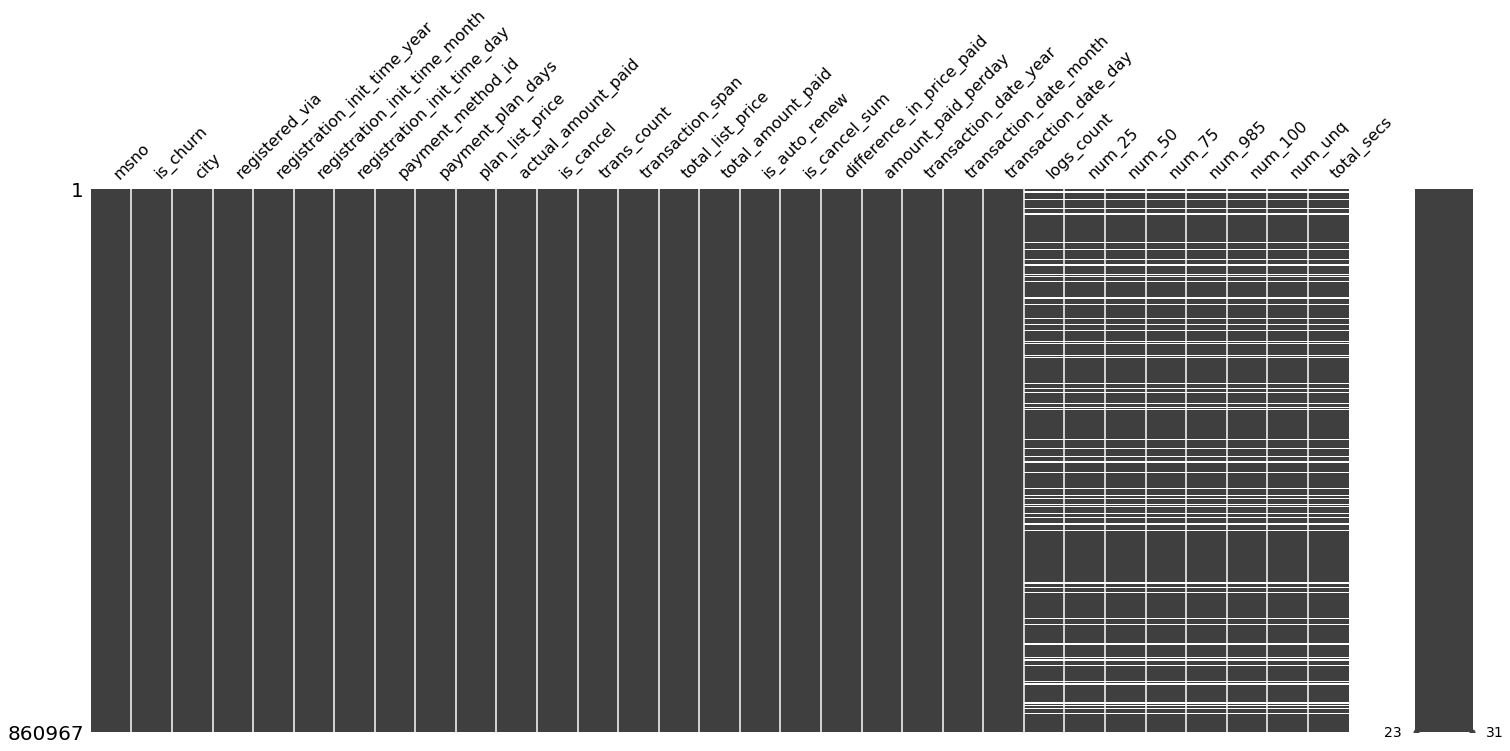

In [15]:
ms.matrix(final)
plt.savefig('missing values.png')
plt.show()

In [16]:
final = final.dropna(axis = 0, how = 'any')

In [17]:
final.loc[:,'is_churn'] = final['is_churn'].astype(int).astype('category')
final.loc[:,'city'] = final['city'].astype(int).astype('category')
final.loc[:,'registered_via'] = final['registered_via'].astype(int).astype('category')
final.loc[:,'registration_init_time_year'] = final['registration_init_time_year'].astype(int).astype('category')
final.loc[:,'registration_init_time_month'] = final['registration_init_time_month'].astype(int).astype('category')
final.loc[:,'registration_init_time_day'] = final['registration_init_time_day'].astype(int).astype('category')
final.loc[:,'payment_method_id'] = final['payment_method_id'].astype('category')
final.loc[:,'payment_plan_days'] = final['payment_plan_days'].astype('category')
final.loc[:,'is_cancel'] = final['is_cancel'].astype('category')
final.loc[:,'is_auto_renew'] = final['is_auto_renew'].astype('category')
final.loc[:,'transaction_date_year'] = final['transaction_date_year'].astype('category')
final.loc[:,'transaction_date_month'] = final['transaction_date_month'].astype('category')
final.loc[:,'transaction_date_day'] = final['transaction_date_day'].astype('category')
final.loc[:,'logs_count'] = final['logs_count'].astype('int')
final.loc[:,'num_25'] = final['num_25'].astype(int)
final.loc[:,'num_50'] = final['num_50'].astype(int)
final.loc[:,'num_75'] = final['num_75'].astype(int)
final.loc[:,'num_985'] = final['num_985'].astype(int)
final.loc[:,'num_100'] = final['num_100'].astype(int)
final.loc[:,'num_unq'] = final['num_unq'].astype(int)

In [18]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754532 entries, 0 to 860966
Data columns (total 31 columns):
msno                            754532 non-null object
is_churn                        754532 non-null category
city                            754532 non-null category
registered_via                  754532 non-null category
registration_init_time_year     754532 non-null category
registration_init_time_month    754532 non-null category
registration_init_time_day      754532 non-null category
payment_method_id               754532 non-null category
payment_plan_days               754532 non-null category
plan_list_price                 754532 non-null int64
actual_amount_paid              754532 non-null int64
is_cancel                       754532 non-null category
trans_count                     754532 non-null int64
transaction_span                754532 non-null int64
total_list_price                754532 non-null int64
total_amount_paid               754532 non-null int

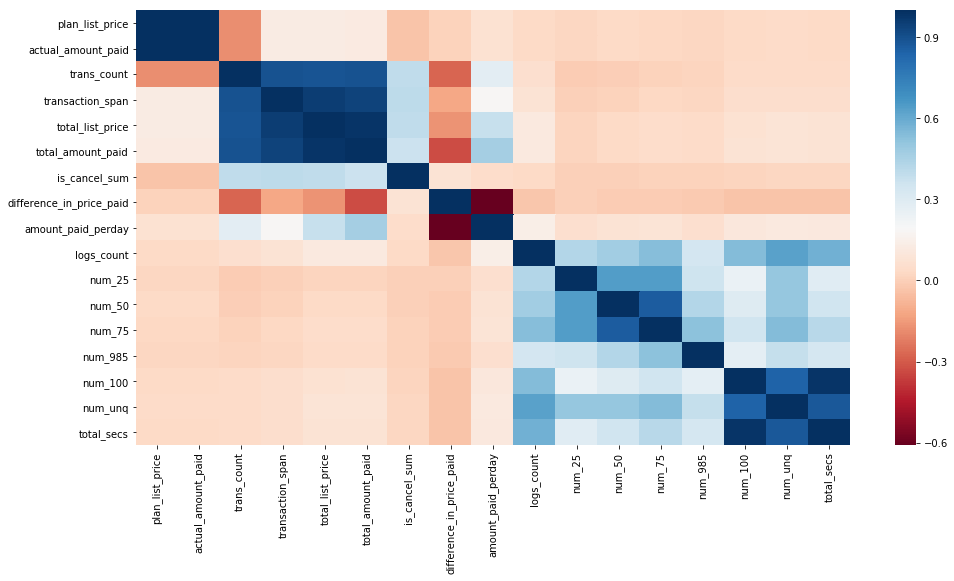

In [19]:
corr = final.corr()
plt.figure(figsize = (16,8))
sns.heatmap(corr, cmap = 'RdBu', annot = False)
plt.savefig('final correlation.png')
plt.show()

# Train - Test split.

In [20]:
X = final.drop(['is_churn','msno'],axis=1)
y = final['is_churn']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
#Data preparation for XGB
X_xgb = X
X_xgb_category = X_xgb.select_dtypes(include=['category'])

X_xgb = pd.get_dummies(data=X, columns=X_xgb_category.columns)
y_xgb = y.astype('int8')
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2)

# Model Building.

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_proba_logreg = logreg.predict_proba(X_test)
print('Logistic Regression log-loss : ' + str(log_loss(y_test, y_pred_proba_logreg)))

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)
print('Decision Tree Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_dt)))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
print('Random Forest Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_rf)))

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
y_pred_proba_gbc = gbc.predict_proba(X_test)
print('Gradient-Boosting Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_gbc)))

ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)
y_pred_proba_ada = ada.predict_proba(X_test)
print('AdaBoost Classifier log-loss : ' + str(log_loss(y_test, y_pred_proba_ada)))

xgbc = XGBClassifier()
gbm = xgbc.fit(X_xgb_train, y_xgb_train)
y_pred_xgb = gbm.predict(X_xgb_test)
y_pred_prob_xgb = gbm.predict_proba(X_xgb_test)
print('XGBoost Classifier log-loss : ' + str(log_loss(y_xgb_test, y_pred_prob_xgb)))

Logistic Regression log-loss : 0.22209674041173338
Decision Tree Classifier log-loss : 2.045223255812666
Random Forest Classifier log-loss : 0.4088666029233096
Gradient-Boosting Classifier log-loss : 0.116337029490537
AdaBoost Classifier log-loss : 0.6529300903276155


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost Classifier log-loss : 0.11617948283731167


# Parameter Tuning Gradient Boosting 

In [24]:
from sklearn.model_selection import cross_val_score

for i in range(2,8):
    cv_score = cross_val_score(gbc, X_train, y_train, cv = i, scoring = 'neg_log_loss')
    print('log-loss score computed using ' + str(i) + '-fold cross-validation : {}'.format(cv_score.mean()))

log-loss score computed using 2-fold cross-validation : -0.11834347705592087
log-loss score computed using 3-fold cross-validation : -0.11809467746078799
log-loss score computed using 4-fold cross-validation : -0.11815538355575256
log-loss score computed using 5-fold cross-validation : -0.11773585376839465
log-loss score computed using 6-fold cross-validation : -0.11807088609893325
log-loss score computed using 7-fold cross-validation : -0.1183579613097907


In [25]:
from sklearn.model_selection import GridSearchCV

param_test_1 = {'n_estimators':range(50,401,50)}

gbc = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
                                 max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_1, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train, y_train)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))
gbc_cv.grid_scores_

Tuned Gradient Boosting Parameters: {'n_estimators': 300}
Best score is -0.1074797143086088


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.11247, std: 0.00106, params: {'n_estimators': 50},
 mean: -0.10894, std: 0.00090, params: {'n_estimators': 100},
 mean: -0.10816, std: 0.00087, params: {'n_estimators': 150},
 mean: -0.10779, std: 0.00079, params: {'n_estimators': 200},
 mean: -0.10759, std: 0.00079, params: {'n_estimators': 250},
 mean: -0.10748, std: 0.00075, params: {'n_estimators': 300},
 mean: -0.10749, std: 0.00075, params: {'n_estimators': 350},
 mean: -0.10750, std: 0.00073, params: {'n_estimators': 400}]

In [26]:
param_test_2 = {'max_depth':range(8,11,1), 'min_samples_split':range(600,1201,200)}

gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate=0.1, min_samples_leaf = 50, max_features='sqrt',
                                 subsample=0.8,random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_2, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train, y_train)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))
gbc_cv.grid_scores_

Tuned Gradient Boosting Parameters: {'max_depth': 10, 'min_samples_split': 800}
Best score is -0.10742019995355326


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.10773, std: 0.00078, params: {'max_depth': 8, 'min_samples_split': 600},
 mean: -0.10762, std: 0.00082, params: {'max_depth': 8, 'min_samples_split': 800},
 mean: -0.10796, std: 0.00089, params: {'max_depth': 8, 'min_samples_split': 1000},
 mean: -0.10779, std: 0.00082, params: {'max_depth': 8, 'min_samples_split': 1200},
 mean: -0.10756, std: 0.00074, params: {'max_depth': 9, 'min_samples_split': 600},
 mean: -0.10751, std: 0.00070, params: {'max_depth': 9, 'min_samples_split': 800},
 mean: -0.10767, std: 0.00085, params: {'max_depth': 9, 'min_samples_split': 1000},
 mean: -0.10757, std: 0.00088, params: {'max_depth': 9, 'min_samples_split': 1200},
 mean: -0.10743, std: 0.00071, params: {'max_depth': 10, 'min_samples_split': 600},
 mean: -0.10742, std: 0.00076, params: {'max_depth': 10, 'min_samples_split': 800},
 mean: -0.10752, std: 0.00072, params: {'max_depth': 10, 'min_samples_split': 1000},
 mean: -0.10764, std: 0.00074, params: {'max_depth': 10, 'min_samples_split': 1

In [29]:
param_test_3 = {'min_samples_leaf':range(1, 10, 2)}


gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate=0.1, min_samples_split=800,
                                 max_depth=10,max_features='sqrt',subsample=0.8,random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_3, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train, y_train)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))
gbc_cv.grid_scores_

Tuned Gradient Boosting Parameters: {'min_samples_leaf': 9}
Best score is -0.10735827663480652


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.10779, std: 0.00087, params: {'min_samples_leaf': 1},
 mean: -0.10748, std: 0.00085, params: {'min_samples_leaf': 3},
 mean: -0.10742, std: 0.00076, params: {'min_samples_leaf': 5},
 mean: -0.10742, std: 0.00086, params: {'min_samples_leaf': 7},
 mean: -0.10736, std: 0.00066, params: {'min_samples_leaf': 9}]

In [30]:
param_test_4 = {'max_features':range(5,31,2)}


gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate=0.1, min_samples_split=800,
                                 max_depth=10, min_samples_leaf = 9 , subsample=0.8, random_state=10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_4, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train, y_train)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))
gbc_cv.grid_scores_

Tuned Gradient Boosting Parameters: {'max_features': 29}
Best score is -0.10665174445253942


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.10736, std: 0.00066, params: {'max_features': 5},
 mean: -0.10715, std: 0.00071, params: {'max_features': 7},
 mean: -0.10692, std: 0.00069, params: {'max_features': 9},
 mean: -0.10702, std: 0.00072, params: {'max_features': 11},
 mean: -0.10690, std: 0.00064, params: {'max_features': 13},
 mean: -0.10681, std: 0.00059, params: {'max_features': 15},
 mean: -0.10672, std: 0.00074, params: {'max_features': 17},
 mean: -0.10675, std: 0.00071, params: {'max_features': 19},
 mean: -0.10669, std: 0.00067, params: {'max_features': 21},
 mean: -0.10676, std: 0.00062, params: {'max_features': 23},
 mean: -0.10666, std: 0.00074, params: {'max_features': 25},
 mean: -0.10680, std: 0.00075, params: {'max_features': 27},
 mean: -0.10665, std: 0.00050, params: {'max_features': 29}]

In [31]:
param_test_5 = {'subsample':[0.85, 0.9, 0.95]}


gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, min_samples_split = 800,
                                 max_depth = 10, min_samples_leaf = 9 , max_features = 29, random_state = 10)

gbc_cv = GridSearchCV(gbc, param_grid = param_test_5, scoring = 'neg_log_loss', n_jobs = 4, cv = 5)
gbc_cv.fit(X_train, y_train)

print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))
gbc_cv.grid_scores_

Tuned Gradient Boosting Parameters: {'subsample': 0.95}
Best score is -0.10626507324180809


C:\Users\dgurram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.10654, std: 0.00055, params: {'subsample': 0.85},
 mean: -0.10652, std: 0.00054, params: {'subsample': 0.9},
 mean: -0.10627, std: 0.00072, params: {'subsample': 0.95}]

In [32]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=6000,max_depth=10, min_samples_split=800,
                                         min_samples_leaf=9, subsample=0.95, random_state=10, max_features=29)
gbm_tuned_1.fit(X_train, y_train)
y_pred_proba = gbm_tuned_1.predict_proba(X_test)
print('log-loss : ' + str(log_loss(y_test, y_pred_proba)))

log-loss : 0.1026813547203256


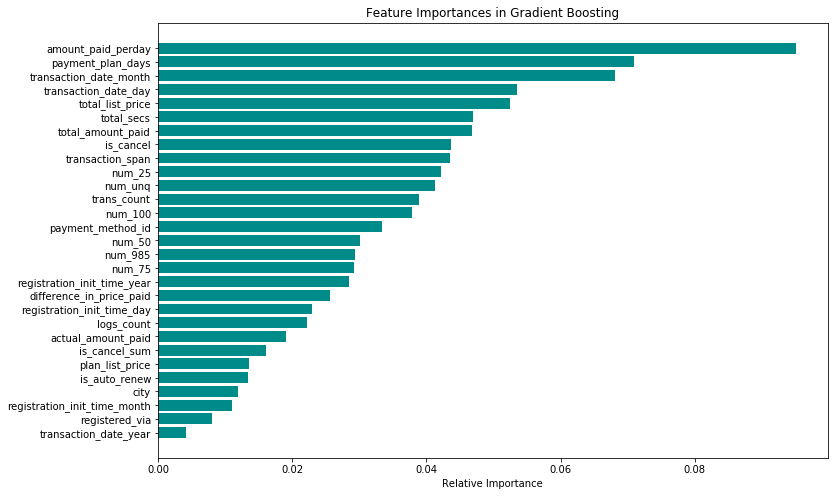

In [33]:
plt.figure(figsize=(12,8))
features = X_train.columns
importances = gbm_tuned_1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances in Gradient Boosting')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost.

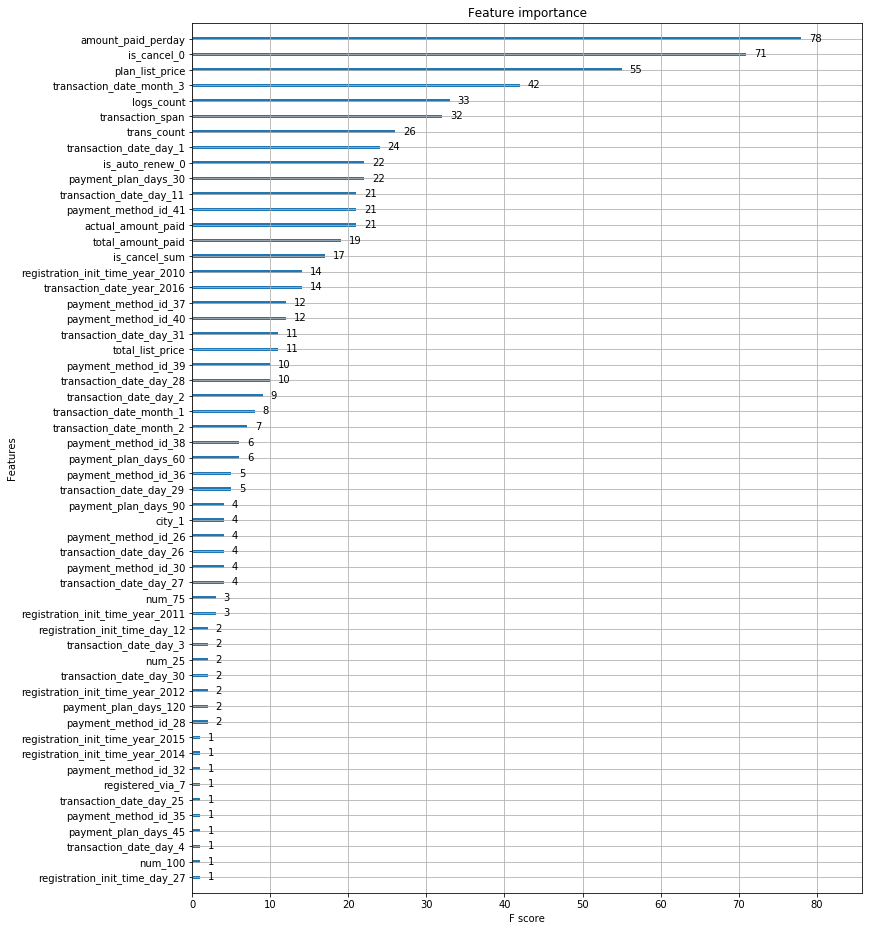

In [39]:
# XGBoost Feature Importance Plot
fig, ax = plt.subplots(figsize=(12,16))
xgb.plot_importance(gbm, ax=ax)
plt.yticks()
plt.show()